# Overview and Abstract
- Deep Learning Group K
  - Shubhada Bhaskarao Sanap - 202088939
  - Claudia Cook - 202087427
  - Georgios Gkolfinopoulos - 202072474
  - Nishant Lohan - 202074866

- Multiclassification problem
- Process: First some preprocessing of the data was done, dealing with missing values and unbalanced dataset. The dataset was also hot-encoded so that the problem could be approached as multiclass but also as multilabel. We employed a Random Forest as a baseline Machine Learning model, a Neural Network with different configurations and finally a BERT model.
- Findings: Baseline ML model gave suprisingly high accuracy given the simplicy of it, a score in kaggle of around 85%. The score was better improved by a Deep Neural Network (91%) which we think is the best model for this dataset. BERT model gave good performance but showed no significant increase as compared to the neural network, and has a much longer training time therefore is not the model we would choose for this dataset.

# Method
##Data Processing
The first thing performed was one-hot-encoding. The new dataframe contains the target values in string format in the column 'label' but also contains each class in binary format. This was done due to observation of the performance of our neural network, which worked better when the problem was approached as multilabel.
The training data was then inspected for missing values. The column 'values' was missing more than 50% so this column was dropped right away. 17 missing values were found in 'nature_of_contract' and these rows were dropped. It was also evident that the country related columns wouldnt contribute useful information so they were both dropped as well.
A common problem notably affecting performance is unbalanced dataset. We observed one of the classes 'Infrastructure & Construction' was hugely overepresented, making the NN predict mainly this class. We decided to undersample the dataset to solve this problem.
For the test dataset the same columns were dropped and the single missing value in nature_of_contract was replaced.


---



##Baseline ML model

We tried logistic regression and random forest. Logistic regression was employed for its simplicity, however it is not very powerful and performs better for binary problems. This method calculates probabilities of belonging to a certain class.
We then chose Random Forests. This is a popular ensemble method applied for both classificaiton and regression problems, and is known to work better for unbalanced datasets and multiclass problems. It is less impacted by outliers, handles larger amounts of data better, and is less likely to overfit [1].



---



##Neural Network

Different configurations of neural networks were modified and evaluated for performance. The first and most simple NN was composed of an embedding layer, 1 dense layers and an output layer. This gave a score of 0.1 in kaggle; so it was clear we had to fine tune parameters or add different layers.
The first layer has to be an embedding layer from keras, which turns positive integers (indexes) into dense vectors of fixed size [2].

###Model 1
Model 1 contains a input embedding layer, a pooling layer, a dense layer (100 neurons), a dropout layer and another dense layer (50). The final layer is an output layer with 9 neurons; one for each class.
The pooling layer after the embedding layer downsamples the input representation by taking the maximum value. 
The activation used in the dense layers is RELU, since we want outputs to be positive, and it overcomes the vanishing gradient problem allowing models to learn faster and perform better. It is simple and very powerful, it otuputs the input if it is positive, and outputs 0 otherwise. It is claimed to perform better than others such as Sigmoid and TanH [3].

The activation for the output layer in any multilabel classiffication problem needs to be softmax, and the loss function employed to compile the model was binary crossentropy, both supported by literature [4].
One of the best optimizers with most advanatges is Adam [5] which was also emeployed.

###Model 2
A more complex model was employed to attempt to fine tune model 1. To this model we added another dense layer with 50 neurons and 3 dropout layers. 

---

## BERT

For the BERT model we used resources from the youtube channel in the references [6].
The tokenization is further explained in the code below, and there is a function below called "bert_encode" responsible for it, but the novel part of this tokenization compared to the one performed for the neural network is we build our vocabulary using the the BERT tokenizer, which already contains background connextions in the language.
The model contains 3 input layers that take in token ids, mask and type ids. Then a pooling layer a dropout layer and a dense layer. We did not increase the complexity in this model becasue the training times were over 1h.



---

We explored many different combinations of text, for instance we trained one of the initial models on just the 'title' column, which was proven to be an important feature since the performance was reasonable. We observed that the performance was further increased by adding "contract_type", "nature_of_contract" and "sector", so we used these for the more complex models.
One one ocasion, for the BERT model, we added the column 'awarding authority', but the increase in accuracy was marginal.
The column awarding authority was added to the BERT model but the token list was too long and the model could not be trained.

For the baseline ML model, we thought eliminating the classes that appear less than 5 times should increase accuracy. It did but only 2%.

Below are the packages and imports along with useful functions.

In [1]:
##packages/imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

!pip install cython pyyaml==5.1 #need to to this becasue it gives error in following 2 imports
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

import os
import tensorflow as tf
import tensorflow_hub as hub

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

In [34]:
## FUNCTIONS

# these are the ones that take input predictions and prepare them for submission
#this one for baseline
def prepare_submission_multiclass(pred):
  pred_df = pd.DataFrame(pred)
  ids = df_test[['docid']]
  df_pred_subm = pd.concat([ids,pred_df], axis=1)
  df_pred_subm = df_pred_subm.rename(columns = {0: 'label'})
  return(df_pred_subm)

#this one for NN and BERT
def prepare_submission_multilabel(pred):
  predL = (pred >= .5).astype(int) ## transform values into 1's and 0's
  dfpre = pd.DataFrame(predL) # put into dataframe
  #this next line converts the columns with each label into a single string 
  dfpre['Pred_Labels'] = (dfpre[0].map(str) + dfpre[1].map(str)+ dfpre[2].map(str)+ dfpre[3].map(str)+ dfpre[4].map(str)+ dfpre[5].map(str)+ dfpre[6].map(str)++ dfpre[7].map(str)+ dfpre[8].map(str))
  #this adapts it for submission style
  ids = df_test[['docid']] #adding first column with docid
  df_pred_subm = pd.concat([ids,dfpre.Pred_Labels], axis=1) #adding second column of predicted labes
  df_pred_subm = df_pred_subm.rename(columns={"Pred_Labels":"label"}) #changing column name
  return(df_pred_subm)



  # functions for BERT section, tokenizations

def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs


# Results and Discussion
## Baseline ML models
Logistic regression gave 40% in kaggle only trained on the 'title' column of the dataset; which was still higher than we expected. Random Forest was applied, with the training data extended to columns "contract_type", "nature_of_contract","sector" and "title". These are the 4 columns that gave better results, we will refer to these as "the selected 4".The test acuracy was 85%, with a score of 84% in kaggle which is a great improvement from the logistic regression model. Moreover, we attempted a bit of data processing here to improve the score, eliminating labels that appeared less than 4 times, reducing number of labels in training set from 132 to 78. This showed a slight increase of accuracy in kaggle (87%).



---




## NN model
Surprisingly, the simpler model (model 1) gave better performance on the training set (0.913%). It is a relatively simple configuration but it has proven to be very powerful. We attempted to add more layers into the model (model 2) and it resulted in a decrease of accuracy.
We found that a smaller batch size of 32 gave more acurate results than batch size of, for instance 100.
In any case, for different variations of parameters, training and testing accuracies are very similar; which shows that the model is learning efficiently and does not overfitting on the training data; it is able to generalize well for unseen data.
In the graphs in the code section we can see that both training and validation losses decrease steadily during training.



---


## BERT model
The model performed well but was not a significant increase compared to model 1 (0.91436%). The training and computation times are much longer so this model does not seem to be the most efficient for this dataset. We tried different configurations and added a new column to the text, "awarding authority", but again this did not result in a significant increase in accuracy (0.91512%) and resulted in longer computation times. This also verifies that the selected 4 are the most significant, and awarding authority is not an importat attribute.

Adding desciption to the BERT model caused the program to give an unknown error, which we think could be due to a vocabulary size that is too large.
Also, 'title' was proven to be a very important attribute since a logistic regression model was trained on this column and gave an accuracy of 40%.



##Table of performances
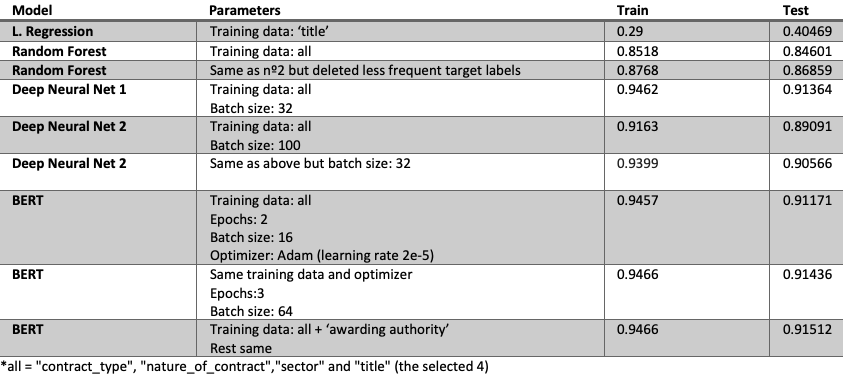

# Summary and Recommendation

We think that for this particular dataset the simple NN (Model 1) employed offers very good performance on the test set (0.9136), and the BERT model offers just slightly better performance (0.9151). The training time is significantly longer for the BERT model, which can take up to 1 hour. For this reason we suggest the simple NN, that with it's current configuration takes just around 1 minute to run. Nevertheless, It could be explored and further refined with different layers to improve accuracy, or maybe saved and retrained on the larger dataset to give better results. 
At the same time, the model employed for BERT was very simple and could be further refined, even if this means even longer training times but it could potentially give better results. 

#References

[1] S. Gupta, “Pros and cons of various Classification ML algorithms,” Medium, Jun. 23, 2020. https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6 

[2] K. Team, “Keras documentation: Embedding layer.” https://keras.io/api/layers/core_layers/embedding/

[3] R. Maksutov, “Deep study of a not very deep neural network. Part 2: Activation functions,” Medium, Jul. 11, 2018. https://towardsdatascience.com/deep-study-of-a-not-very-deep-neural-network-part-2-activation-functions-fd9bd8d406fc

[4] J. Brownlee, “Multi-Label Classification with Deep Learning,” Machine Learning Mastery, Aug. 30, 2020. https://machinelearningmastery.com/multi-label-classification-with-deep-learning/

[5] S. Doshi, “Various Optimization Algorithms For Training Neural Network,” Medium, Aug. 03, 2020. https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6

[6] “(16) adam0ling - YouTube.” https://www.youtube.com/channel/UCu6JhqCuDiAjhSI6YdHYu_Q 

and other useful links:
https://medium.com/swlh/multi-label-text-classification-with-scikit-learn-and-tensorflow-257f9ee30536
https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/






# Code

Feature Processing
- Report how your processed the data here or in a separate notebook (provide link if a separate notebook is used).

Training and Validating etc.
- Show your working here – where you report all your training and validation, etc. that you performed in order to get the results.
- Note that it is important that you results can be replicated. All code to reproduce the final predictions must be included, along with any code that justifies your choices.

Any Additional Analysis
- Add in any additional analysis etc that you performed here.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. Feature Processing
Final processed sets are df_train and df_test. Get these dataframes before anything else

###Training dataset
**df_train**

In [3]:
path = "/content/drive/MyDrive/Strath/ML/Assignment2ML/german-contracts-train.csv"
df = pd.read_csv(path,  dtype={
        "docid":str,
        "publication_date":str,
        "contract_type":str,
        "nature_of_contract":str,
        "country_code":str,
        "country_name":str,
        "sector":str,
        "category":str,
        "value":float,
        "title":str,
        "description":str,
        "awarding_authority":str,
        "label":str  
    })

In [4]:
df.head(2)

,docid,publication_date,contract_type,nature_of_contract,country_code,country_name,sector,category,value,title,description,awarding_authority,label
0,2493527426,2020-10-14,award,services,DE,Germany,public,['Energy & Environment'],75658.0,Germany-Wilhelmshaven: Cleaning services,Unterhalts- und Glasreinigung.\n,Staatliches Baumanagement Ems-Weser,000100000
1,2538215982,2020-11-16,notice,services,DE,Germany,public,['Infrastructure & Construction'],NaN,Germany-Dresden: Engineering-design services f...,ABS Karlsruhe-Stuttgart-Nürnberg-Leipzig/Dresd...,DB Netz AG,000001000


In [5]:
df.shape

(98320, 13)

####One-hot-encoding
We found that treating the problem as multiclass worked fine for basic ML models. However, predicting each class separately: aproaching the task as multilabel, workes better for neural networks. Therefore, we will modify the original training dataframe to also include occurences of individual classes in binary format.
The classic method for one-hot-encoding didn't work for unknown reasons, we deidiced to solve the problem manually assigning each number in the label column to the correct class column

In [6]:
df_complete = df.copy() 
labels = [["General", "Defence", "Education & Culture", "Energy & Environment", "Health & Care", "Infrastructure & Construction","Professional Services","Technology & Communications","Transport & Logistics"]]
df_complete.head(2)

,docid,publication_date,contract_type,nature_of_contract,country_code,country_name,sector,category,value,title,description,awarding_authority,label
0,2493527426,2020-10-14,award,services,DE,Germany,public,['Energy & Environment'],75658.0,Germany-Wilhelmshaven: Cleaning services,Unterhalts- und Glasreinigung.\n,Staatliches Baumanagement Ems-Weser,000100000
1,2538215982,2020-11-16,notice,services,DE,Germany,public,['Infrastructure & Construction'],NaN,Germany-Dresden: Engineering-design services f...,ABS Karlsruhe-Stuttgart-Nürnberg-Leipzig/Dresd...,DB Netz AG,000001000


In [7]:
for i in labels:
  df_complete[i] = 0 ## just add 0's to all class columns

In [8]:
row = df_complete.shape[0] # number of rows in df
for x in range(row):
  val = df_complete['label'][x] ## complete label for that row
  df_complete['General'][x] = val[0] # first number in label is ocurrence or not of 'general' class, and so on..
  df_complete['Defence'][x] = val[1] 
  df_complete['Education & Culture'][x] = val[2] 
  df_complete['Energy & Environment'][x] = val[3] 
  df_complete['Health & Care'][x] = val[4] 
  df_complete['Infrastructure & Construction'][x] = val[5] 
  df_complete['Professional Services'][x] = val[6] 
  df_complete['Technology & Communications'][x] = val[7] 
  df_complete['Transport & Logistics'][x] = val[8]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: Se

In [9]:
df_complete.head(2)

,docid,publication_date,contract_type,nature_of_contract,country_code,country_name,sector,category,value,title,description,awarding_authority,label,General,Defence,Education & Culture,Energy & Environment,Health & Care,Infrastructure & Construction,Professional Services,Technology & Communications,Transport & Logistics
0,2493527426,2020-10-14,award,services,DE,Germany,public,['Energy & Environment'],75658.0,Germany-Wilhelmshaven: Cleaning services,Unterhalts- und Glasreinigung.\n,Staatliches Baumanagement Ems-Weser,000100000,0,0,0,1,0,0,0,0,0
1,2538215982,2020-11-16,notice,services,DE,Germany,public,['Infrastructure & Construction'],NaN,Germany-Dresden: Engineering-design services f...,ABS Karlsruhe-Stuttgart-Nürnberg-Leipzig/Dresd...,DB Netz AG,000001000,0,0,0,0,0,1,0,0,0


####Missing Values

In [10]:
df_complete.isnull().any()
df_complete.isnull().sum() 
# column 'value' is no good, almost 50% values are missing
# there are just a few in 'nature_of_contract', we can just drop these rows which are 17

docid                                0
publication_date                     0
contract_type                        0
nature_of_contract                  17
country_code                         0
country_name                         0
sector                               0
category                             0
value                            63078
title                                0
description                          0
awarding_authority                   0
label                                0
General                              0
Defence                              0
Education & Culture                  0
Energy & Environment                 0
Health & Care                        0
Infrastructure & Construction        0
Professional Services                0
Technology & Communications          0
Transport & Logistics                0
dtype: int64

In [11]:
df_complete = df_complete.drop(labels ="value",axis = 1) # drop value column
df_complete = df_complete.dropna()#drop rows where there are NANS
df_complete.isnull().values.any()

False

We will also delete the columns country_code & country_name becasue they both represent Germany and dont contribute information

In [12]:
df_complete = df_complete.drop(labels ="country_code",axis = 1) # drop value column
df_complete = df_complete.drop(labels ="country_name",axis = 1) # drop value column

####Visualizations

Check balance and labels per row

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


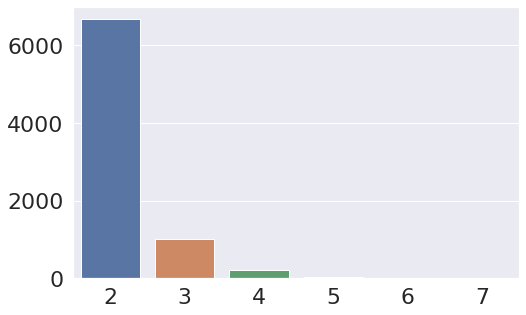

In [13]:
rowSums = df_complete.iloc[:,10:].sum(axis=1) # labels are from column 10 onwards
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(8,5))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.show()


most of them have 2 labels, some 3

Check balance of labels

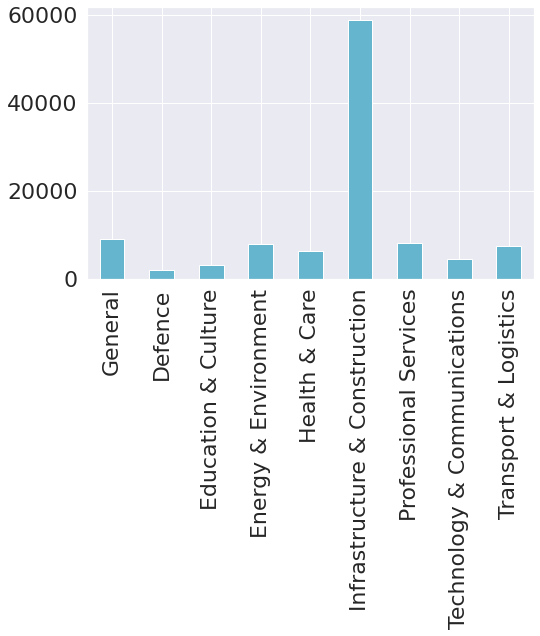

In [14]:
labels = ["General", "Defence", "Education & Culture", "Energy & Environment", "Health & Care", "Infrastructure & Construction","Professional Services","Technology & Communications","Transport & Logistics"]

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

df_complete[labels].sum(axis=0).plot.bar(color = 'c')
plt.show()

Very unbalanced, the class "Infrastructure & Construction" is overrepresented. If we dont do anythig about this our models will predict a vast mojority of just this label.
There are various methods to dealing with an unbalanced dataset, we found undersampling worked fairly well

In [15]:
df_balance = df_complete.copy()
df_balance = df_balance[1:80000] ## delete labels from first 80000 (dont want to delete all)
df_balance.drop(df_balance[df_balance['Infrastructure & Construction'] == 1].index, inplace = True)

# Add the rest of untouched rows
df_balance = pd.concat([df_balance,df_complete[80001:]], axis=0)

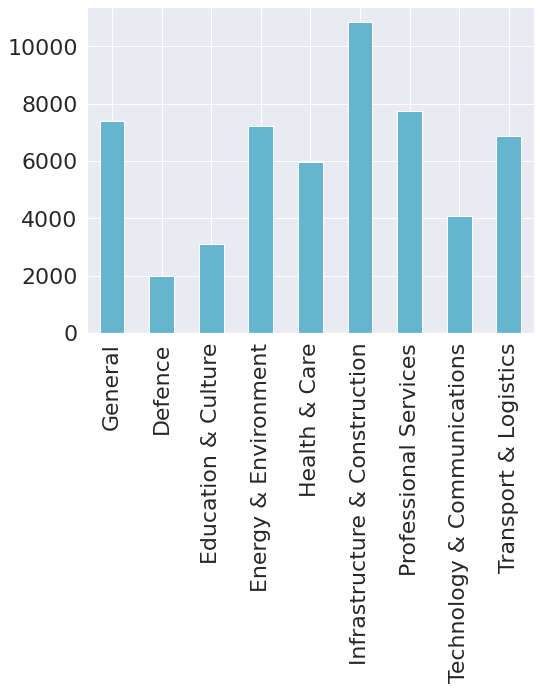

In [16]:
## END RESULT
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

df_balance[labels].sum(axis=0).plot.bar(color = 'c')
plt.show()

In [17]:
print(df_complete.shape)
print(df_balance.shape) ## from 98303 to 50281 rows.
df_train = df_balance.copy()

(98303, 19)
(50281, 19)


###Test dataset
**df_test**
There is no processing here we will just deal with missing values now

In [18]:
path2 = "/content/drive/MyDrive/Strath/ML/Assignment2ML/german-contracts-test.csv"
df_test = pd.read_csv(path2)

In [19]:
df_test.head(2)

,docid,publication_date,contract_type,nature_of_contract,country_code,country_name,sector,value,title,description,awarding_authority
0,2535443526,2020-11-13,notice,services,DE,Germany,public,NaN,Germany-Stuttgart: Software-related services,Pflege und Anpassung SKoKa-BW (1.1.2021-31.12....,"Regierungspräsidium Tübingen, Abteilung 9 — La..."
1,2487195007,2020-10-09,notice,services,DE,Germany,public,NaN,"Germany-Mühlacker: Architectural, construction...",Vergabeverfahren der Stadt Mühlacker zur Verga...,Stadtverwaltung Mühlacker


In [20]:
df_test.isnull().sum()

docid                     0
publication_date          0
contract_type             0
nature_of_contract        1
country_code              0
country_name              0
sector                    0
value                 15825
title                     0
description               0
awarding_authority        0
dtype: int64

In [21]:
# 1. Drop values column
df_test = df_test.drop(labels ="value",axis = 1)
# 2. Replace single missing value in the nature of contract column. (dont want to delete row becasue set number of rows for submissions)
nature_of_contract_NEW = df_test.nature_of_contract.fillna(method='ffill') # propagate non-null values forward or backward: replaces the value with the one before it.
df_test.nature_of_contract = nature_of_contract_NEW

In [22]:
df_test.isnull().any()

docid                 False
publication_date      False
contract_type         False
nature_of_contract    False
country_code          False
country_name          False
sector                False
title                 False
description           False
awarding_authority    False
dtype: bool

In [23]:
df_test = df_test.drop(labels ="country_code",axis = 1) # drop value column
df_test = df_test.drop(labels ="country_name",axis = 1) # drop value column

##2. Training and validating

###Baseline ML

In [35]:
X = df_train.copy()
y = df_train.label
X['Text'] = (X['contract_type'].map(str) +' '+ X['nature_of_contract'].map(str) +' '+ X['sector'].map(str)+' '+ X['title'].map(str)).apply(lambda row: row.strip())
X = X['Text']

In [36]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=32)

Tokenization and Padding

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Size of the vocabulary of our text, i.e. maximum integer index + 1.
print('Vocab size: ',vocab_size)

Vocab size:  4549


In [38]:
# Example of first row of text with tokenized values
print(x_train[3])
print(X_train[3])

notice supplies public Germany-Limbach: Boards
[5, 3, 1, 2, 13, 34, 3, 30, 12, 24, 32, 7, 31]


In [39]:
# need to get max length of input sequences
length_train = [len(i) for i in X_train]
length_test = [len(i) for i in X_test]
lens = length_train + length_test

maxlength = np.max(lens)
print('Max length:', maxlength)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlength) ## padding of encoded rows with 0's so all are same length. 'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.
X_test = pad_sequences(X_test, padding='post', maxlen=maxlength)


Max length: 30


In [40]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlength) ## padding of encoded rows with 0's so all are same length. 'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.
X_test = pad_sequences(X_test, padding='post', maxlen=maxlength)

In [41]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train) #Fit training set
clf.score(X_test, y_test) ## evaluation on test set

0.8486626230486228

In [42]:
## PREPARE TEST SET FOR PREDICTION
XT = df_test.copy()
XT['Text'] = (XT['contract_type'].map(str) +' '+ XT['nature_of_contract'].map(str) +' '+ XT['sector'].map(str)+' '+ XT['title'].map(str)).apply(lambda row: row.strip())
XT = XT['Text']
XT = tokenizer.texts_to_sequences(np.array(XT))  # vectorizes using the tokenizer for the training set
XT = pad_sequences(XT, padding='post', maxlen=maxlength)  # adds padding

In [43]:
# predictions
predictions = clf.predict(XT)

In [44]:
predictionsdf = prepare_submission_multiclass(predictions)
predictionsdf.head()

,docid,label
0,2535443526,000000100
1,2487195007,000001000
2,2573583192,000010000
3,2213029015,000001000
4,2218957610,000001000


In [45]:
# save predictions
#predictionsdf.to_csv('/content/drive/MyDrive/Strath/ML/Assignment2ML/df_pred_subm(RF).csv',index=False)

###Neural Network

In [46]:
X = df_train.copy()

In [47]:
# get target values but this time in binary form 
labels = ["General", "Defence", "Education & Culture", "Energy & Environment", "Health & Care", "Infrastructure & Construction","Professional Services","Technology & Communications","Transport & Logistics"]
ybool = X[labels]
ybool.head(2)

,General,Defence,Education & Culture,Energy & Environment,Health & Care,Infrastructure & Construction,Professional Services,Technology & Communications,Transport & Logistics
3,1,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,1,0


In [48]:
# same as for baseline really
X['Text'] = (X['contract_type'].map(str) +' '+ X['nature_of_contract'].map(str) +' '+ X['sector'].map(str)+' '+ X['title'].map(str)).apply(lambda row: row.strip())

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X.Text.values, ybool.values, test_size=0.20, random_state=32)

In [50]:
## tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train) #goes through all the text and gives unique index to each unique word

X_train = tokenizer.texts_to_sequences(x_train) #maps those indexes to corresponding words
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Size of the vocabulary of our text, i.e. maximum integer index + 1.
print('vocab size', vocab_size)

# need to get max length of input sequences
length_train = [len(i) for i in X_train]
length_test = [len(i) for i in X_test]
lens = length_train + length_test

maxlength = np.max(lens)
print('Max length:', maxlength)

vocab size 4549
Max length: 30


In [51]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlength) ## padding of encoded rows with 0's so all are same length. 'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.
X_test = pad_sequences(X_test, padding='post', maxlen=maxlength)

#### MODEL 1

In [52]:
embedding_dim = 100  # (vector form of the text we are inputting in the model)

model1 = Sequential()  # initiates the model
#1st layer is an embedding layer
model1.add(layers.Embedding(input_dim=vocab_size,  #Integer. Size of the vocabulary of our text, i.e. maximum integer index + 1. (how many unique words there were in total)
                          output_dim=embedding_dim,  # Integer. Dimension of the dense embedding. length of embedding layer output
                        input_length=maxlength))  #  Length of input sequences, determined by maxlen calculated before
model1.add(layers.GlobalMaxPool1D()) 
model1.add(layers.Dense(100, activation='relu'))  # additional hidden layer
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(50, activation='relu'))
model1.add(layers.Dense(9, activation='sigmoid'))  # prediction layer, 2 is the number of classes we have
model1.compile(loss='binary_crossentropy', optimizer='adam')
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           454900    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 459       
Total params: 470,509
Trainable params: 470,509
Non-trainable params: 0
__________________________________________________

In [53]:
history = model1.fit(X_train, y_train,
                    epochs=3,  # times model will run through the data
                    verbose=True,
                    validation_split=0.2, # we havent created a validation set so take it from training set
                    batch_size=32) # data is set to batches we are sent to the model to predict, imagine each batc as a step in which model tries to predict the class and then checks the right answer and corrects it's weights with backpropogation
 ## tried batch size 32, 50, 100

Epoch 1/3
1006/1006 [==============================] - 8s 7ms/step - loss: 0.3097 - accuracy: 0.4817 - val_loss: 0.0725 - val_accuracy: 0.9177
Epoch 2/3
1006/1006 [==============================] - 7s 7ms/step - loss: 0.0630 - accuracy: 0.9277 - val_loss: 0.0570 - val_accuracy: 0.9334
Epoch 3/3
1006/1006 [==============================] - 7s 7ms/step - loss: 0.0443 - accuracy: 0.9436 - val_loss: 0.0533 - val_accuracy: 0.9354


In [54]:
loss, accuracy = model1.evaluate(X_train,y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9436
Testing Accuracy:  0.9379


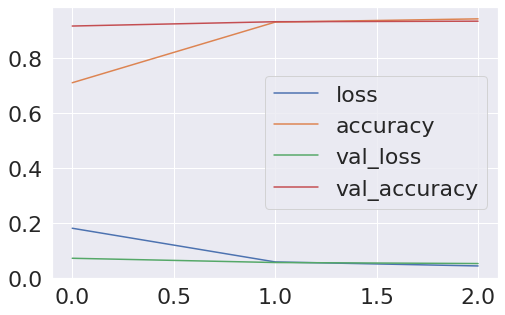

In [55]:

pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)

In [56]:
## PREPARE TEST SET FOR PREDICTION
XT = df_test.copy()
XT['Text'] = (XT['contract_type'].map(str) +' '+ XT['nature_of_contract'].map(str) +' '+ XT['sector'].map(str)+' '+ XT['title'].map(str)).apply(lambda row: row.strip())
XT = XT['Text']
XT = tokenizer.texts_to_sequences(np.array(XT))  # vectorizes using the tokenizer for the training set
XT = pad_sequences(XT, padding='post', maxlen=maxlength)  # adds padding

In [57]:
# predictions
predictions = model1.predict(XT)


In [58]:
predictionsdf = prepare_submission_multilabel(predictions)
predictionsdf.head()

,docid,label
0,2535443526,000000100
1,2487195007,000001000
2,2573583192,100000000
3,2213029015,000001000
4,2218957610,000001000


In [59]:
# save predictions
#predictionsdf.to_csv('/content/drive/MyDrive/Strath/ML/Assignment2ML/df_pred_submodel1.csv',index=False)

#### MODEL 2

In [60]:
embedding_dim = 100  # (vector form of the text we are inputting in the model)

model2 = Sequential()  # initiates the model
#1st layer is an embedding layer
model2.add(layers.Embedding(input_dim=vocab_size,  #Integer. Size of the vocabulary of our text, i.e. maximum integer index + 1. (how many unique words there were in total)
                          output_dim=embedding_dim,  # Integer. Dimension of the dense embedding. length of embedding layer output
                        input_length=maxlength))  #  Length of input sequences, determined by maxlen calculated before
model2.add(layers.Dropout(0.2))  #covers 20% of outputs from the embedding layer, preventing overfitting
model2.add(layers.GlobalMaxPool1D())  #reducing amount of layers we look at
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(50, activation='relu'))  # additional hidden layer
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(9, activation='sigmoid'))  # prediction layer, 2 is the number of classes we have
model2.compile(loss='binary_crossentropy', optimizer='adam')
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           454900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)               

In [61]:
history = model2.fit(X_train, y_train,
                    epochs=3,  # times model will run through the data
                    verbose=True,
                    validation_split=0.2, # we havent created a validation set so take it from training set
                    batch_size=32) # data is set to batches we are sent to the model to predict, imagine each batc as a step in which model tries to predict the class and then checks the right answer and corrects it's weights with backpropogation
 ## tried batch size 32, 50, 100

Epoch 1/3
1006/1006 [==============================] - 8s 7ms/step - loss: 0.3272 - accuracy: 0.4104 - val_loss: 0.0877 - val_accuracy: 0.8885
Epoch 2/3
1006/1006 [==============================] - 7s 7ms/step - loss: 0.0899 - accuracy: 0.8906 - val_loss: 0.0688 - val_accuracy: 0.9193
Epoch 3/3
1006/1006 [==============================] - 7s 7ms/step - loss: 0.0708 - accuracy: 0.9162 - val_loss: 0.0609 - val_accuracy: 0.9306


In [62]:
loss, accuracy = model2.evaluate(X_train,y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9392
Testing Accuracy:  0.9342


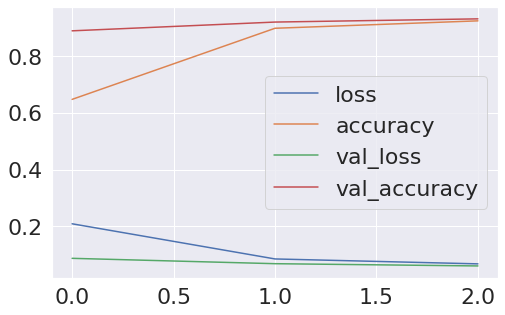

In [63]:

pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)

In [64]:
## PREPARE TEST SET FOR PREDICTION
XT = df_test.copy()
XT['Text'] = (XT['contract_type'].map(str) +' '+ XT['nature_of_contract'].map(str) +' '+ XT['sector'].map(str)+' '+ XT['title'].map(str)).apply(lambda row: row.strip())
XT = XT['Text']
XT = tokenizer.texts_to_sequences(np.array(XT))  # vectorizes using the tokenizer for the training set
XT = pad_sequences(XT, padding='post', maxlen=maxlength)  # adds padding

In [65]:
# predictions
predictions = model2.predict(XT)


In [66]:
predictionsdf = prepare_submission_multilabel(predictions)
predictionsdf.head()

,docid,label
0,2535443526,000000100
1,2487195007,000001000
2,2573583192,100000000
3,2213029015,000001000
4,2218957610,000001000


In [67]:
# save predictions
#predictionsdf.to_csv('/content/drive/MyDrive/Strath/ML/Assignment2ML/df_pred_submMODEL2.csv',index=False)

###BERT

In [77]:
X = df_train.copy()
labels = ["General", "Defence", "Education & Culture", "Energy & Environment", "Health & Care", "Infrastructure & Construction","Professional Services","Technology & Communications","Transport & Logistics"]
ybool = X[labels]

In [78]:
X['Text'] = (X['contract_type'].map(str) +' '+ X['nature_of_contract'].map(str) +' '+ X['sector'].map(str)+' '+ X['title'].map(str)).apply(lambda row: row.strip())

In [79]:
x_train, x_test, y_train, y_test = train_test_split(X.Text.values, ybool.values, test_size=0.20, random_state=32)

Bert needs 3 inputs, unlike the previous NN.
NN: tokenized text.
BERT: tokenized text, input mask (show model where inputs are), input type

In [80]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2", trainable=True)
# model from tensorflow, multilingual so trained on more than one language, also takes into account if words are upper or lower case
# but we set it so we can further train it on our data


In [81]:
# these are variables from the loaded model
# we are not building a vocabulary file like in NN, we are reading the ones that are there thaks to BERT
# with these 2 inputs we build our BERT tokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]']) # classiffication and separation tokens

[101, 102]

In [82]:
def encode_names2(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]') 
   return tokenizer.convert_tokens_to_ids(tokens)

data = tf.ragged.constant([encode_names2(n) for n in x_train])

print('Tokenized text shape', data.shape.as_list())

Tokenized text shape [40224, None]


In [83]:
data[0] #here we can see a tensor of the indices. in NN each word corresponds to one index. here the indices can be assigned to combinations of tokens, a token...

<tf.Tensor: shape=(14,), dtype=int32, numpy=
array([17725, 12639, 11683, 12775,   118, 15021,   131, 16680, 96898,
       21493, 12142, 21849, 12639,   102], dtype=int32)>

In [84]:
## add classification token
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*data.shape[0]
input_word_ids = tf.concat([cls, data], axis=-1)


Still need input mask and input type

In [85]:
input_mask = tf.ones_like(input_word_ids).to_tensor()


In [86]:
type_cls = tf.zeros_like(cls)
type_data = tf.ones_like(data)
input_type_ids = tf.concat([type_cls, type_data], axis=-1).to_tensor()


In [87]:
input_type_ids ## 0's are the CLS token that is added at the start of each row

<tf.Tensor: shape=(40224, 54), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [88]:
lens = [len(i) for i in input_word_ids]

In [89]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 54


In [90]:
#max_seq_length = int(1.5*max_seq_length)
#print('Max length is:', max_seq_length)

In [91]:
# call function to encode with BERT
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

####MODEL BERT

In [92]:
num_class = 9  # specify the number of classes that can be predicted
max_seq_length = max_seq_length  # size of our inputs
# 3 input layers that correspond to inputs that were just made: ids, masks and type ids

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])    ## 2 different BERT layers                              

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output) # just use pooled output and add dropout layer to prevent overtraining/fitting

output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='output')(output) #dense predict layer

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

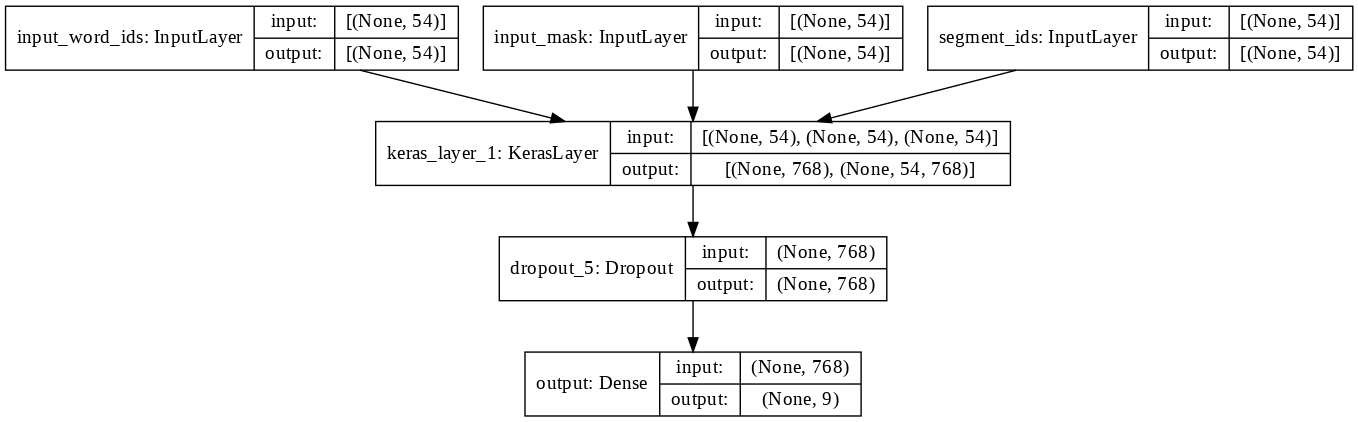

In [93]:
# model summary
tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

Within the keras_layer is the BERT layer, which of course doesnt have 1 layer but is represented here as if it were 1 

In [94]:
epochs = 3 
batch_size = 32
eval_batch_size = batch_size

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

opt = keras.optimizers.Adam(learning_rate=2e-5)

In [95]:
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [96]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 54)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 54)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 54)]         0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [97]:
history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,verbose=1)

Epoch 1/3
1006/1006 [==============================] - 440s 426ms/step - loss: 0.1590 - accuracy: 0.7715 - val_loss: 0.0590 - val_accuracy: 0.9361
Epoch 2/3
1006/1006 [==============================] - 435s 433ms/step - loss: 0.0551 - accuracy: 0.9389 - val_loss: 0.0549 - val_accuracy: 0.9412
Epoch 3/3
1006/1006 [==============================] - 438s 435ms/step - loss: 0.0477 - accuracy: 0.9459 - val_loss: 0.0526 - val_accuracy: 0.9416


In [98]:
loss, accuracy = model.evaluate(X_train,y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9458
Testing Accuracy:  0.9420


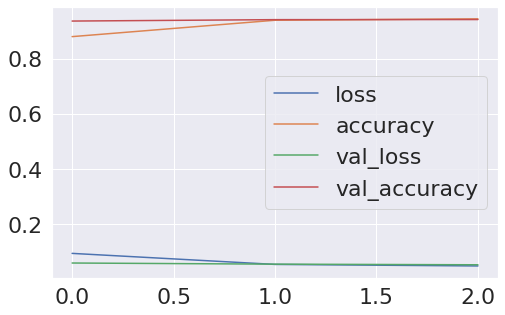

In [99]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)

PREDICTIONS

In [100]:
XT = df_test.copy()
XT['Text'] = (XT['contract_type'].map(str) +' '+ XT['nature_of_contract'].map(str) +' '+ XT['sector'].map(str)+' '+ XT['title'].map(str)).apply(lambda row: row.strip())
XT = XT['Text']
inputs = bert_encode(XT, tokenizer=tokenizer, max_seq_length=max_seq_length)

In [104]:
# predictions
predictions = model.predict(inputs)

In [105]:
predictionsdf=prepare_submission_multilabel(predictions)

In [106]:
predictionsdf

,docid,label
0,2535443526,000000100
1,2487195007,000001000
2,2573583192,100000000
3,2213029015,000001000
4,2218957610,000001000
...,...,...
24576,2259192964,000001000
24577,2354536398,000001000
24578,2351916922,000001000
24579,2578322526,000001000


In [ ]:
# save predictions
#predictionsdf.to_csv('/content/drive/MyDrive/Strath/ML/Assignment2ML/df_pred_subm.csv',index=False)